# Chapter 6 - Organisation Matching

In [11]:
import requests
import json
import zipfile
import io
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

## Step 1 - Data Acquisition

### Companies House Basic Data

In [ ]:
# UK Companies House Basic Company Data download page

url="http://download.companieshouse.gov.uk/en_output.html"

In [ ]:
# Download snapshots, convert json to dataframe, remove unwanted columns and append to a single dataframe

df_ct = pd.DataFrame()
with requests.Session() as req:
        r = req.get(url)
        soup = BeautifulSoup(r.content, 'html.parser')
        snapshots = [f"{url[:38]}{item['href']}" for item in soup.select(
            "a[href*='BasicCompanyData-']")]
        for snapshot in snapshots:    
            response = requests.get(snapshot).content     
            zipsnapshot = zipfile.ZipFile(io.BytesIO(response))
            tempfile = zipsnapshot.extract(zipsnapshot.namelist()[0])
            print(zipsnapshot.namelist()[0])
            df_c = pd.read_csv(tempfile, dtype='unicode')
            df_c = df_c[['RegAddress.PostCode','CompanyName']]
            df_ct = pd.concat([df_ct, df_c], ignore_index=True)

### Maritime and Coastguard Agency

In [ ]:
# Maritime and Coastguard Agency - List of approved recruitment and placement agencies

url = "https://www.gov.uk/government/publications/recruitment-and-placement-agencies-approved-by-the-mca"

In [ ]:
# Download the csv file, extract name and drop erroroneous last row with all nulls

with requests.Session() as req:
    r = req.get(url)
    soup = BeautifulSoup(r.content, 'html.parser')
    targets = [f"{item['href']}" for item in soup.select(
        "a[href$='.csv']")]
    for target in targets:
        response = req.get(target)    
        df_m = pd.read_csv(io.BytesIO(response.content))
        df_m = df_m.dropna(how='all')

### Saving to Local Storage

In [2]:
#df_ct.to_csv('basic_raw.csv', index=False)
df_c = pd.read_csv('basic_raw.csv')

#df_m.to_csv('mari_raw.csv', index=False)
df_m = pd.read_csv('mari_raw.csv')

## Step 2 - Data Standardization

In [3]:
#%pip install matplotlib

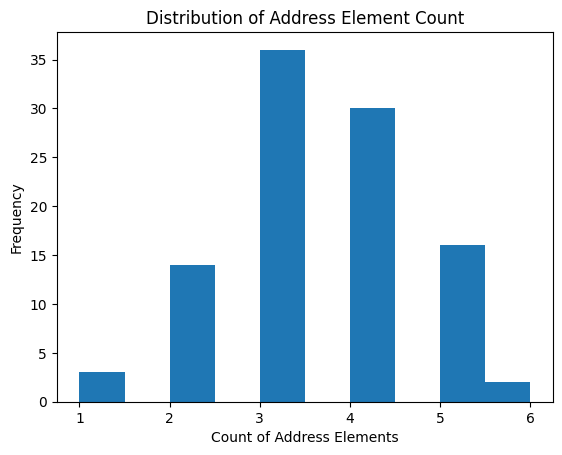

In [10]:
import matplotlib.pyplot as plt

plt.hist(df_m.apply(lambda row: len(row['ADDRESS & CONTACT DETAILS'].split(',')), axis=1).tolist())
plt.xlabel('Count of Address Elements')
plt.ylabel('Frequency')
plt.title('Distribution of Address Element Count')
plt.show()

### Companies House Basic Data

In [ ]:
# Function to remove stopwards from company names

def strip_stopwords(raw_name):    
    company_stopwords = { 'LIMITED', 'LTD', 'SERVICES', 'COMPANY', 'GROUP', 'PROPERTIES', 'CONSULTING', 
        'HOLDINGS', 'UK', 'TRADING', 'LTD.', 'PLC','LLP' }
    return(' '.join([raw_name_part for raw_name_part in raw_name.split() if raw_name_part not in company_stopwords]))

In [ ]:
# Strip company name and rename postcode column

df_c['CompanyName'] = df_c.apply(lambda row: strip_stopwords(row['CompanyName']), axis=1)
df_c = df_c.rename(columns={"RegAddress.PostCode": "Postcode"})

In [ ]:
# Remove unnecessary columns and add index

df_c = df_c[['Postcode','CompanyName']]
df_c['unique_id'] = df_c.index

### Maritime and Coastguard Agency

In [ ]:
# Function to extract postcode using regular expression

import re
def extract_postcode(address):
    pattern = re.compile(r'([A-Z]{1,2}[0-9][A-Z0-9]? [0-9][ABD-HJLNP-UW-Z]{2})')
    postcode = pattern.search(address)
    if(postcode is not None):
         return postcode.group()
    else:
         return None

In [ ]:
# Company name to uppercase

df_m['CompanyName'] = df_m['COMPANY'].str.upper()

In [ ]:
# Strip company name and extract postcode

df_m['CompanyName'] = df_m.apply(lambda row: strip_stopwords(row['CompanyName']), axis=1)
df_m['Postcode'] = df_m.apply(lambda row: extract_postcode(row['ADDRESS & CONTACT DETAILS']), axis=1)

In [ ]:
# Remove unnecessary columns, drop rows with missing data and add index

df_m = df_m[['Postcode','CompanyName']]
df_m = df_m.dropna()
df_m['unique_id'] = df_m.index

len(df_m)

### Saving to Local Storage

In [12]:
#df_c.to_csv('basic_clean.csv', index=False)
df_c = pd.read_csv('basic_clean.csv')

#df_m.to_csv('mari_clean.csv', index=False)
df_m = pd.read_csv('mari_clean.csv')
len(df_m)

96

# Step 3 - Record Blocking and Attribute Comparison

In [13]:
import splink

In [14]:
# Predict only on exact company name or postcode match

from splink.duckdb.linker import DuckDBLinker
from splink.duckdb import comparison_library as cl
settings = {
    "link_type": "link_only",
    "blocking_rules_to_generate_predictions": [
        "l.Postcode = r.Postcode",
        "l.CompanyName = r.CompanyName",
    ],
    "comparisons": [
        cl.jaro_winkler_at_thresholds("CompanyName",[0.9,0.8]),
    ],
    "retain_intermediate_calculation_columns" : True,
    "retain_matching_columns" : True
}
linker = DuckDBLinker([df_m, df_c], settings, input_table_aliases=["_m", "_c"])

In [15]:
linker.cumulative_num_comparisons_from_blocking_rules_chart()

alt.Chart(...)

In [16]:
# Use 1 million targets rows to ensure u estimation

linker.estimate_u_using_random_sampling(max_pairs=1e7)

----- Estimating u probabilities using random sampling -----

Estimated u probabilities using random sampling

Your model is not yet fully trained. Missing estimates for:
    - CompanyName (no m values are trained).


In [17]:
linker.estimate_parameters_using_expectation_maximisation("l.Postcode = r.Postcode")


----- Starting EM training session -----

Estimating the m probabilities of the model by blocking on:
l.Postcode = r.Postcode

Parameter estimates will be made for the following comparison(s):
    - CompanyName

Parameter estimates cannot be made for the following comparison(s) since they are used in the blocking rules: 

Iteration 1: Largest change in params was 0.148 in the m_probability of CompanyName, level `Jaro_winkler_similarity >= 0.9`
Iteration 2: Largest change in params was -0.178 in the m_probability of CompanyName, level `Exact match`
Iteration 3: Largest change in params was -0.0145 in the m_probability of CompanyName, level `Exact match`
Iteration 4: Largest change in params was 0.0207 in the m_probability of CompanyName, level `Jaro_winkler_similarity >= 0.8`
Iteration 5: Largest change in params was 0.034 in the m_probability of CompanyName, level `Jaro_winkler_similarity >= 0.8`
Iteration 6: Largest change in params was 0.0498 in the m_probability of CompanyName, lev

<EMTrainingSession, blocking on l.Postcode = r.Postcode, deactivating comparisons >

In [18]:
#linker.save_model_to_json("Chapter6_Splink_Settings.json", overwrite=True)
linker.load_settings("Chapter6_Splink_Settings.json")

In [19]:
linker.match_weights_chart()

alt.VConcatChart(...)

In [20]:
linker.m_u_parameters_chart()

alt.HConcatChart(...)

# Step 4 - Match Classification

In [21]:
# Calculate predictions

df_pred = linker.predict(threshold_match_probability=0.5).as_pandas_dataframe()
len(df_pred)

110

In [22]:
len(pd.unique(df_pred['CompanyName_r']))

78

In [23]:
postname = df_pred[(df_pred['CompanyName_l']==df_pred['CompanyName_r']) & (df_pred['Postcode_l']==df_pred['Postcode_r'])]
len(postname)

45

In [24]:
len(pd.unique(postname['CompanyName_r']))

43

In [25]:
notname = df_pred[df_pred['CompanyName_l']!=df_pred['CompanyName_r']]
len(notname)

25

In [26]:
len(pd.unique(notname['CompanyName_r']))

12

In [27]:
notpost = df_pred[df_pred['Postcode_l']!=df_pred['Postcode_r']]
len(notpost)

40

In [28]:
len(pd.unique(notpost['CompanyName_r']))

32

In [29]:
results = df_m.merge(df_pred,left_on=['unique_id'], right_on=['unique_id_r'],how='left',
          suffixes=('_m', '_p'))
results[results['match_weight'].isnull()]

,Postcode,CompanyName,unique_id,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,CompanyName_l,CompanyName_r,gamma_CompanyName,bf_CompanyName,Postcode_l,Postcode_r,match_key
0,W1T 2NS,19 LONDON - AS 19 YACHT CREW,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,SO14 3JZ,CB MEDIA (YOTSPOT),13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22,AB21 7GQ,CLAN PARTNERS (INCORPORATING GLOBAL RESOURCE M...,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,HU10 7WG,CP MARINE,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,M50 2EQ,CREW BOARD,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,CT16 3PX,DFDS SEAWAYS BV,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,GU14 7BF,FLUOR INDUSTRIAL,33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,FK16 6EN,JAB MEDIA T/A JAB RECRUITMENT,43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,FY4 6GU,MR MIM WORLD OF ENTERTAINMENT,54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73,KT23 4HN,NEPTUNE MANNING,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
linker.waterfall_chart(df_pred.to_dict(orient="records"))

alt.LayerChart(...)

# Step 5 - Resolve New Entities

In [31]:
record = {
 'source_dataset': "new record",       
 'unique_id': 1,
 'Postcode': "BH15 4QE",
 'CompanyName': "VANTAGE YACHT RECRUITMENT",
}

df_new = linker.find_matches_to_new_records([record]).as_pandas_dataframe()
df_new.sort_values("match_weight", ascending=False)

,match_weight,match_probability,source_dataset_l,source_dataset_r,unique_id_l,unique_id_r,CompanyName_l,CompanyName_r,gamma_CompanyName,bf_CompanyName,Postcode_l,Postcode_r
0,8.470658,0.997189,_m,new record,93,1,VANTAGE YACHT RECRUITMENT,VANTAGE YACHT RECRUITMENT,3,3.547142e+06,BH15 4QE,BH15 4QE
1,0.523024,0.589653,_c,new record,5052254,1,VANTAGE AUTO RECRUITMENT,VANTAGE YACHT RECRUITMENT,2,1.436821e+04,DA1 1RZ,BH15 4QE
2,0.523024,0.589653,_c,new record,5052401,1,VANTAGE HEALTHCARE RECRUITMENT,VANTAGE YACHT RECRUITMENT,2,1.436821e+04,MK14 6GD,BH15 4QE
3,0.523024,0.589653,_c,new record,5052715,1,VANTAGE YACHTING,VANTAGE YACHT RECRUITMENT,2,1.436821e+04,BH19 2PQ,BH15 4QE
